# The Theta Model

The Theta model of Assimakopoulos & Nikolopoulos (2000) is a simple method for forecasting the involves fitting two $\theta$-lines, forecasting the lines using a Simple Exponential Smoother, and then combining the forecasts from the two lines to produce the final forecast.  The model is implemented in steps:


1. Test for seasonality
2. Deseasonalize if seasonality detected
3. Estimate $\alpha$ by fitting a SES model to the data and $b_0$ by OLS.
4. Forecast the series
5. Reseasonalize if the data was deseasonalized.

The seasonality test examines the ACF at the seasonal lag $m$.  If this lag is significantly different from zero then the data is deseasonalize using `statsmodels.tsa.seasonal_decompose` use either a multiplicative method (default) or additive. 

The parameters of the model are $b_0$ and $\alpha$ where $b_0$ is estimated from the OLS regression

$$
X_t = a_0 + b_0 (t-1) + \epsilon_t
$$

and $\alpha$ is the SES smoothing parameter in

$$
\tilde{X}_t = (1-\alpha) X_t + \alpha \tilde{X}_{t-1}
$$

The forecasts are then 

$$
 \hat{X}_{T+h|T} = \frac{\theta-1}{\theta} \hat{b}_0
                     \left[h - 1 + \frac{1}{\hat{\alpha}}
                     - \frac{(1-\hat{\alpha})^T}{\hat{\alpha}} \right]
                     + \tilde{X}_{T+h|T}
$$

Ultimately $\theta$ only plays a role in determining how much the trend is damped.  If $\theta$ is very large, then the forecast of the model is identical to that from an Integrated Moving Average with a drift,

$$
X_t = X_{t-1} + b_0 + (\alpha-1)\epsilon_{t-1} + \epsilon_t.
$$

Finally, the forecasts are reseasonalized if needed.

This module is based on:

* Assimakopoulos, V., & Nikolopoulos, K. (2000). The theta model: a decomposition
  approach to forecasting. International journal of forecasting, 16(4), 521-530.
* Hyndman, R. J., & Billah, B. (2003). Unmasking the Theta method.
  International Journal of Forecasting, 19(2), 287-290.
* Fioruci, J. A., Pellegrini, T. R., Louzada, F., & Petropoulos, F.
  (2015). The optimized theta method. arXiv preprint arXiv:1503.03529.

## Imports

We start with the standard set of imports and some tweaks to the default matplotlib style.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=15)
plt.rc("lines", linewidth=3)
sns.set_style("darkgrid")

## Load some Data

We will first look at housing starts using US data. This series is clearly seasonal but does not have a clear trend during the same. 

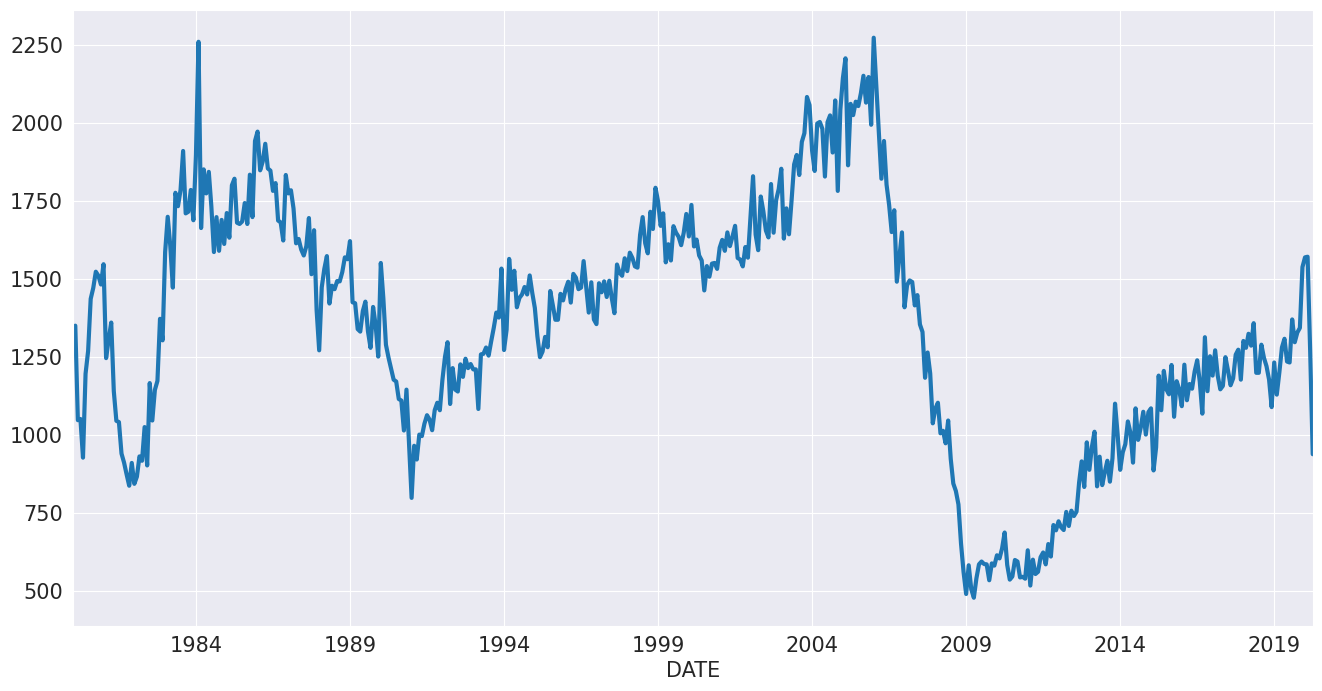

In [2]:
reader = pdr.fred.FredReader(["HOUST"], start="1980-01-01", end="2020-04-01")
data = reader.read()
housing = data.HOUST
housing.index.freq = housing.index.inferred_freq
ax = housing.plot()

We fit specify the model without any options and fit it. The summary shows that the data was deseasonalized using the multiplicative method.  The drift is modest and negative, and the smoothing parameter is fairly low. 

In [3]:
from statsmodels.tsa.forecasting.theta import ThetaModel

tm = ThetaModel(housing)
res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                  HOUST   No. Observations:                  484
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sun, 07 May 2023   Deseas. Method:         Multiplicative
Time:                        10:53:34   Period:                             12
Sample:                    01-01-1980                                         
                         - 04-01-2020                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    -0.9182227350685341
alpha  0.6150174992660694
-------------------------


The model is first and foremost a forecasting method.  Forecasts are produced using the `forecast` method from fitted model. Below we produce a hedgehog plot by forecasting 2-years ahead every 2 years. 

**Note**: the default $\theta$ is 2.

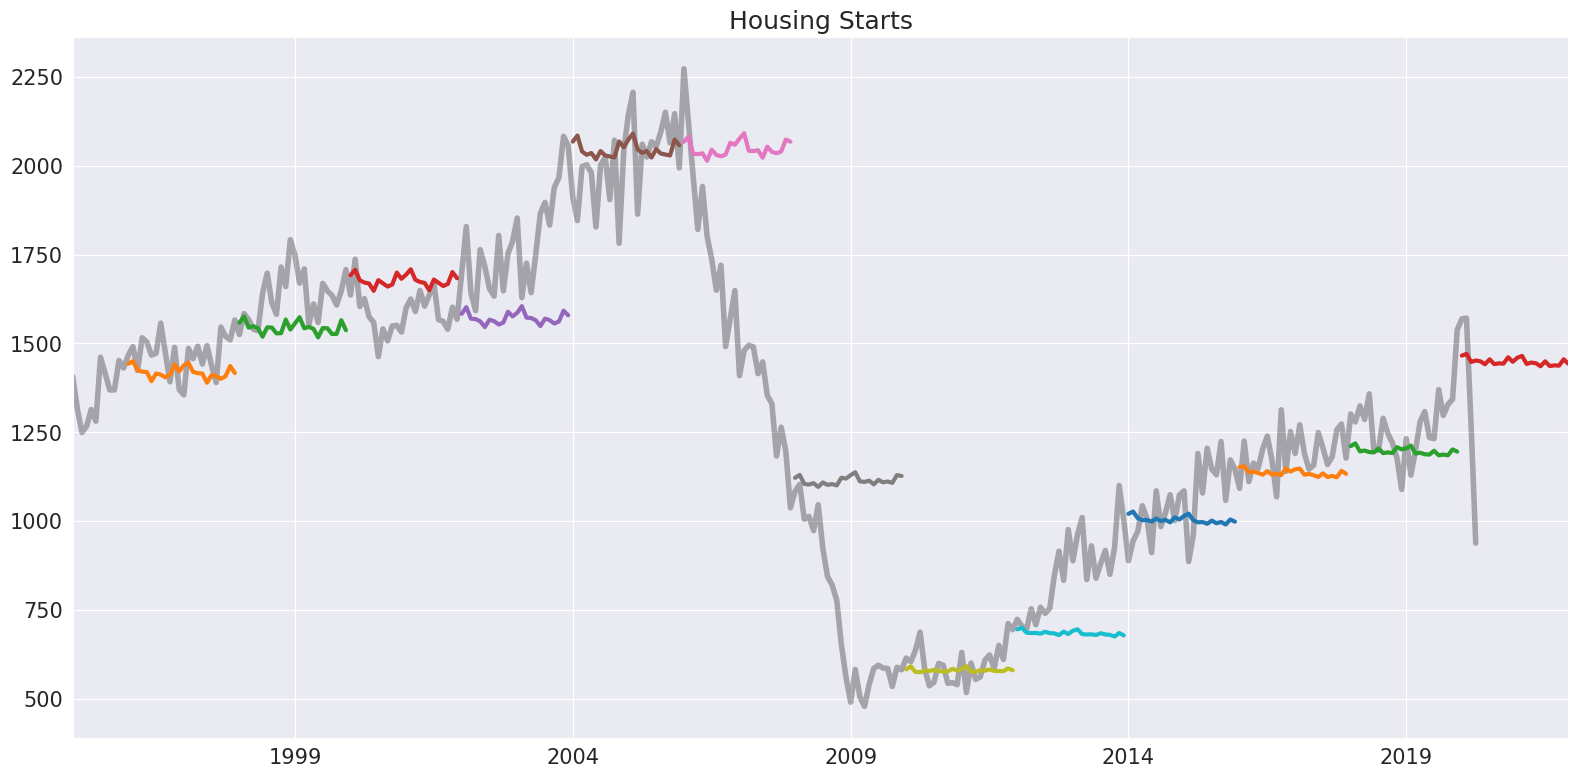

In [4]:
forecasts = {"housing": housing}
for year in range(1995, 2020, 2):
    sub = housing[: str(year)]
    res = ThetaModel(sub).fit()
    fcast = res.forecast(24)
    forecasts[str(year)] = fcast
forecasts = pd.DataFrame(forecasts)
ax = forecasts["1995":].plot(legend=False)
children = ax.get_children()
children[0].set_linewidth(4)
children[0].set_alpha(0.3)
children[0].set_color("#000000")
ax.set_title("Housing Starts")
plt.tight_layout(pad=1.0)

We could alternatively fit the log of the data.  Here it makes more sense to force the deseasonalizing to use the additive method, if needed.  We also fit the model parameters using MLE.  This method fits the IMA

$$ X_t = X_{t-1} + \gamma\epsilon_{t-1} + \epsilon_t $$

where $\hat{\alpha}$ = $\min(\hat{\gamma}+1, 0.9998)$ using `statsmodels.tsa.SARIMAX`. The parameters are similar although the drift is closer to zero.

In [5]:
tm = ThetaModel(np.log(housing), method="additive")
res = tm.fit(use_mle=True)
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                  HOUST   No. Observations:                  484
Method:                           MLE   Deseasonalized:                   True
Date:                Sun, 07 May 2023   Deseas. Method:               Additive
Time:                        10:53:35   Period:                             12
Sample:                    01-01-1980                                         
                         - 04-01-2020                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    -0.000424561126389559
alpha    0.6686378512512897
---------------------------


The forecast only depends on the forecast trend component,
$$
\hat{b}_0
                     \left[h - 1 + \frac{1}{\hat{\alpha}}
                     - \frac{(1-\hat{\alpha})^T}{\hat{\alpha}} \right],
$$

the forecast from the SES (which does not change with the horizon), and the seasonal. These three components are available using the `forecast_components`. This allows forecasts to be constructed using multiple choices of $\theta$ using the weight expression above. 

In [6]:
res.forecast_components(12)

,trend,ses,seasonal
2020-05-01,-0.000635,6.967369,-0.000954
2020-06-01,-0.001060,6.967369,-0.006908
2020-07-01,-0.001484,6.967369,0.002655
2020-08-01,-0.001909,6.967369,-0.003895
2020-09-01,-0.002333,6.967369,-0.004274
2020-10-01,-0.002758,6.967369,-0.004011
2020-11-01,-0.003182,6.967369,0.008384
2020-12-01,-0.003607,6.967369,-0.000926
2021-01-01,-0.004031,6.967369,0.005346
2021-02-01,-0.004456,6.967369,0.010119


## Personal Consumption Expenditure

We next look at personal consumption expenditure. This series has a clear seasonal component and a drift. 

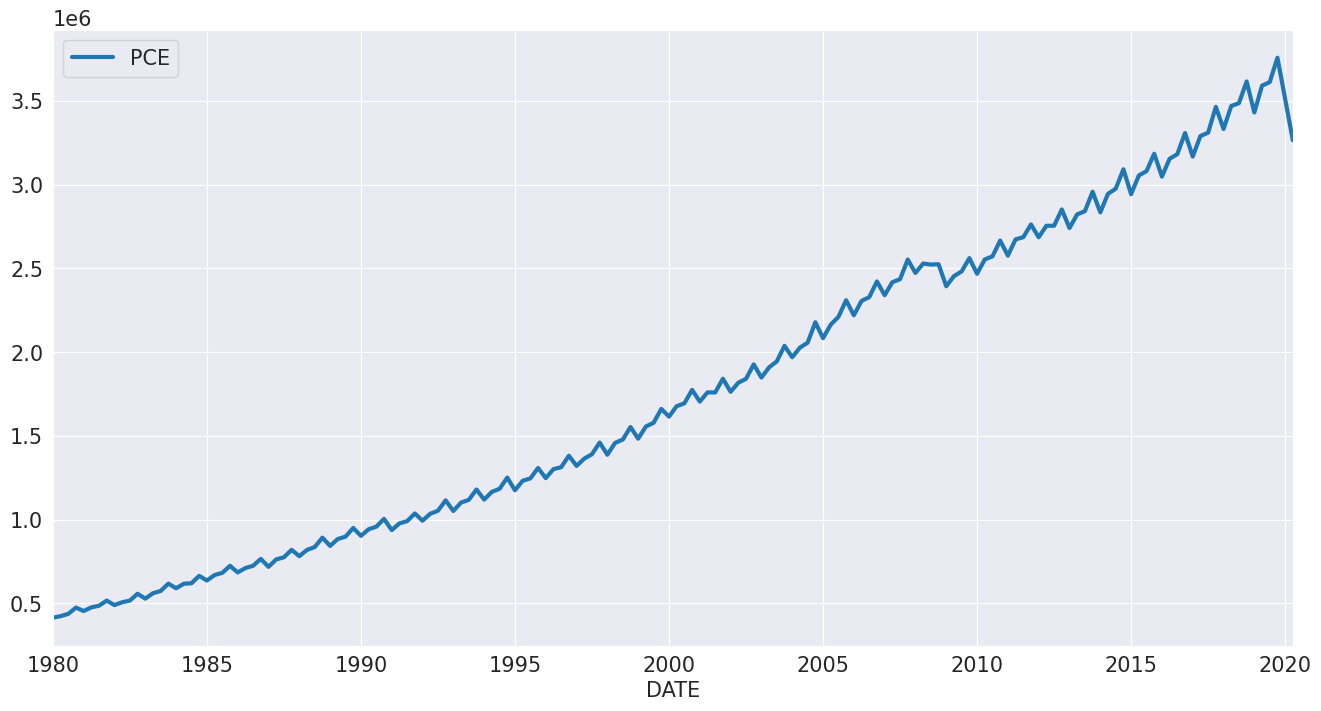

In [7]:
reader = pdr.fred.FredReader(["NA000349Q"], start="1980-01-01", end="2020-04-01")
pce = reader.read()
pce.columns = ["PCE"]
pce.index.freq = "QS-OCT"
_ = pce.plot()

Since this series is always positive, we model the $\ln$.

In [8]:
mod = ThetaModel(np.log(pce))
res = mod.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                    PCE   No. Observations:                  162
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sun, 07 May 2023   Deseas. Method:         Multiplicative
Time:                        10:53:36   Period:                              4
Sample:                    01-01-1980                                         
                         - 04-01-2020                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.013017709693005357
alpha   0.9998843148384222
--------------------------


Next we explore differenced in the forecast as $\theta$ changes. When $\theta$ is close to 1, the drift is nearly absent.  As $\theta$ increases, the drift becomes more obvious.

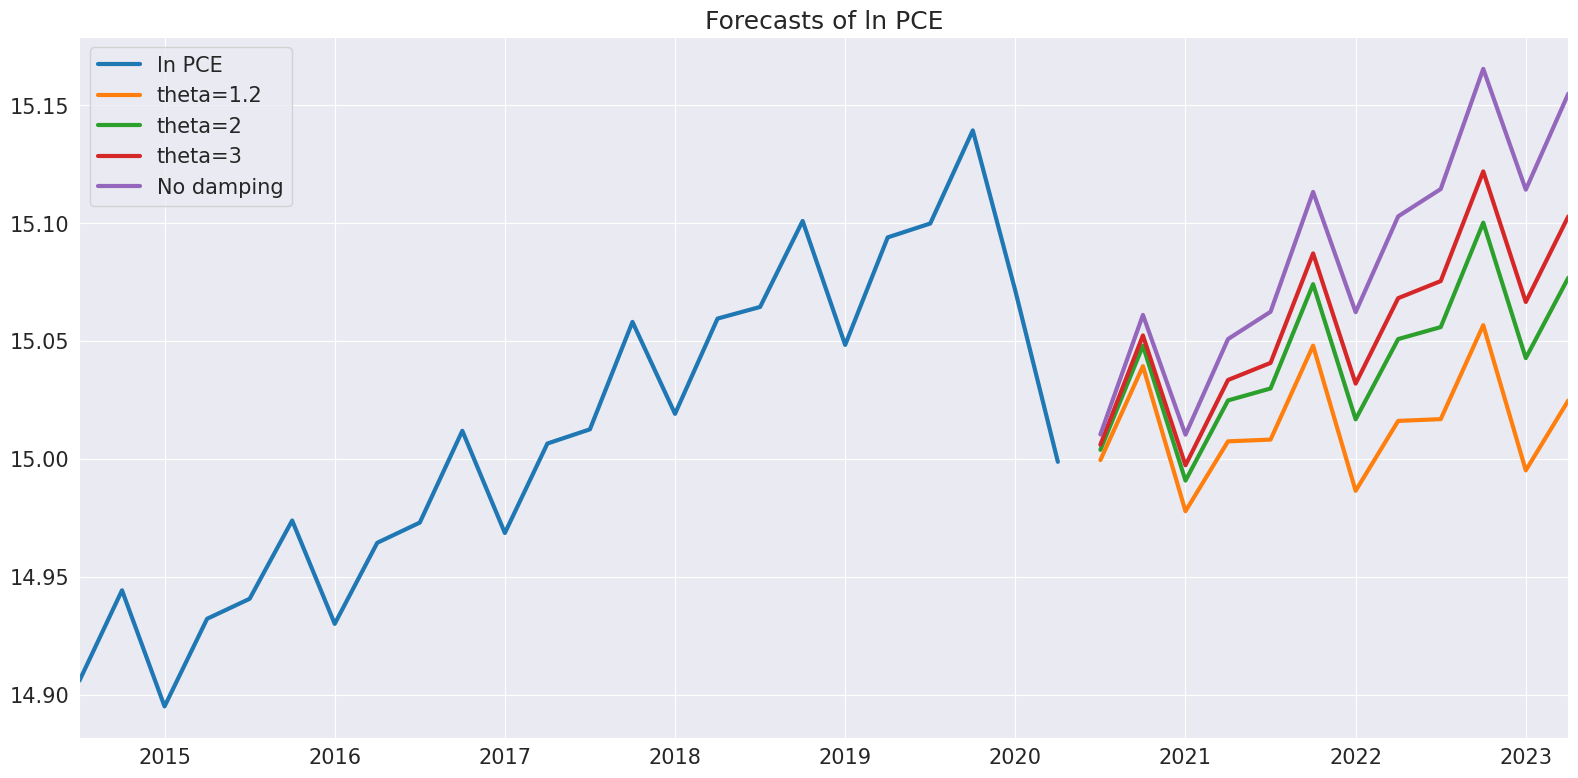

In [9]:
forecasts = pd.DataFrame(
    {
        "ln PCE": np.log(pce.PCE),
        "theta=1.2": res.forecast(12, theta=1.2),
        "theta=2": res.forecast(12),
        "theta=3": res.forecast(12, theta=3),
        "No damping": res.forecast(12, theta=np.inf),
    }
)
_ = forecasts.tail(36).plot()
plt.title("Forecasts of ln PCE")
plt.tight_layout(pad=1.0)

Finally, `plot_predict` can be used to visualize the predictions and prediction intervals which are constructed assuming the IMA is true.

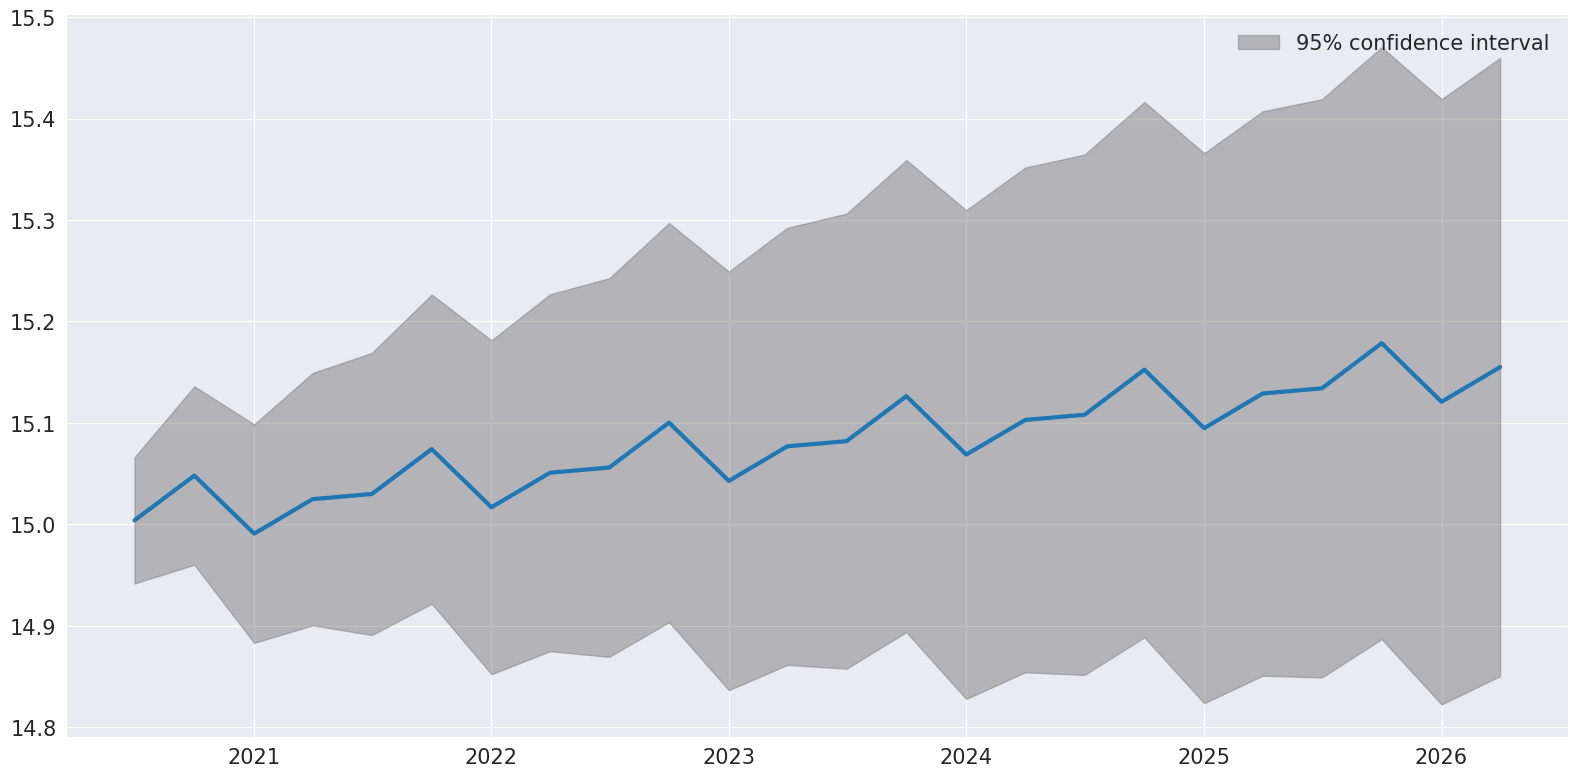

In [10]:
ax = res.plot_predict(24, theta=2)

We conclude be producing a hedgehog plot using 2-year non-overlapping samples.

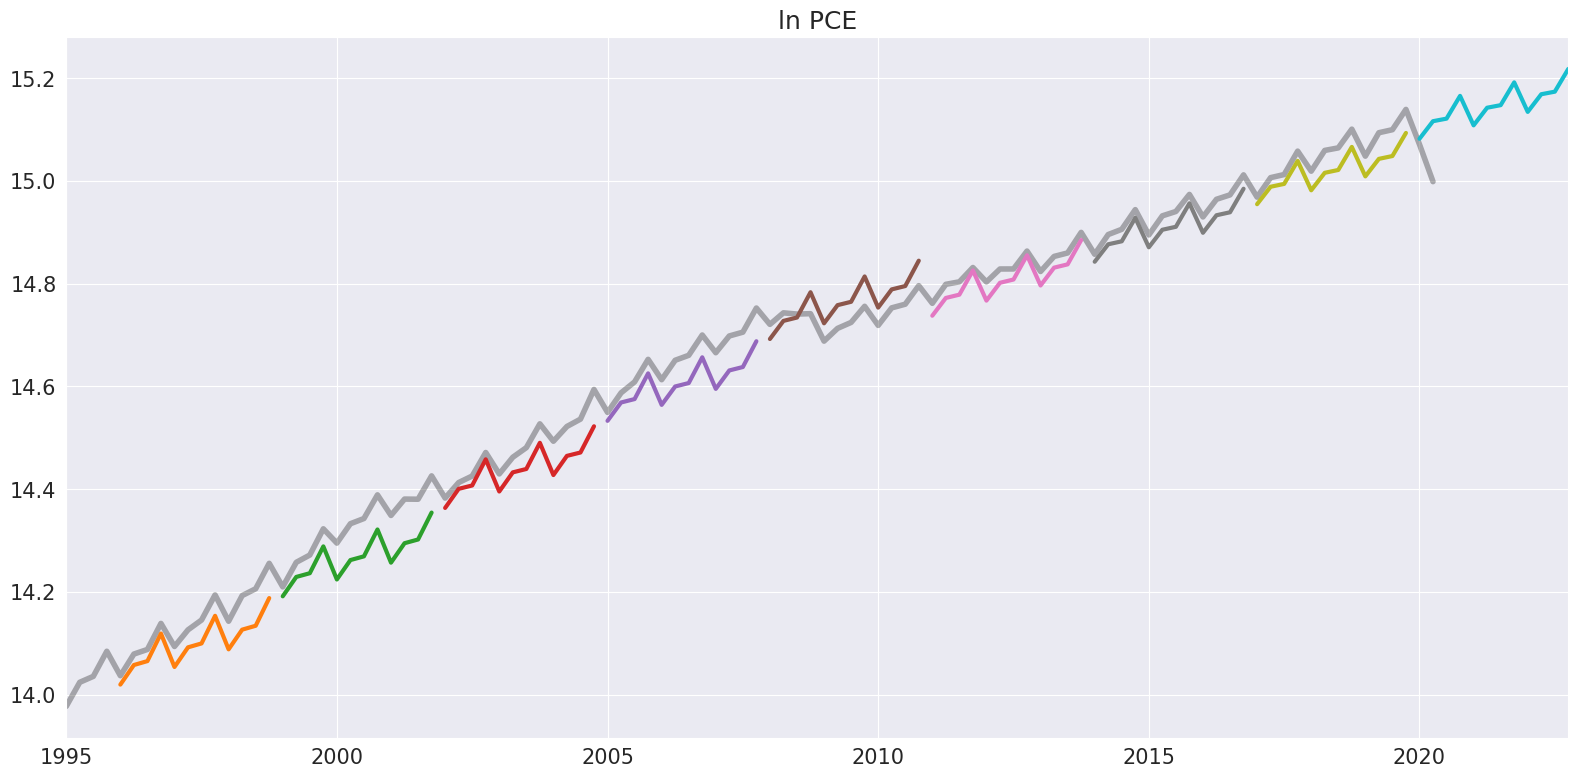

In [11]:
ln_pce = np.log(pce.PCE)
forecasts = {"ln PCE": ln_pce}
for year in range(1995, 2020, 3):
    sub = ln_pce[: str(year)]
    res = ThetaModel(sub).fit()
    fcast = res.forecast(12)
    forecasts[str(year)] = fcast
forecasts = pd.DataFrame(forecasts)
ax = forecasts["1995":].plot(legend=False)
children = ax.get_children()
children[0].set_linewidth(4)
children[0].set_alpha(0.3)
children[0].set_color("#000000")
ax.set_title("ln PCE")
plt.tight_layout(pad=1.0)